In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline

In [2]:
order_products_train = pd.read_csv("Desktop/order_products__train.csv")
order_products_prior = pd.read_csv("Desktop/order_products__prior.csv")
orders = pd.read_csv("Desktop/orders.csv")
products = pd.read_csv("Desktop/products.csv")
aisles = pd.read_csv("Desktop/aisles.csv")
departments = pd.read_csv("Desktop/departments.csv")

In [3]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)


The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [4]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


Missing Data in all orders


In [5]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


There is no missing data in order_products_all dataset



# Reorder Frequency

In [7]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


59 % of ordered products are previously ordered by customers.



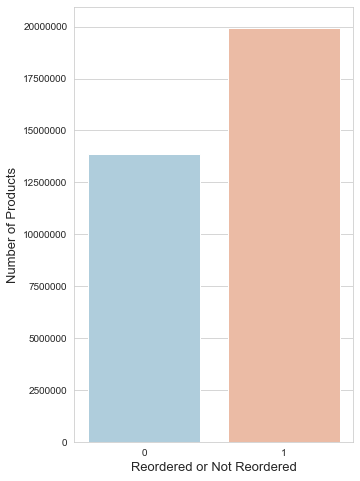

In [8]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

To predict which previously purchased products will be in a user’s next order

In [9]:
orders_df = pd.read_csv("Desktop/orders.csv", usecols=["order_id","user_id","order_number"])


In [10]:
prior_df = pd.read_csv("Desktop/order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


In [11]:
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


In [12]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


In [13]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


In [14]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv("Desktop/order_products__train.csv", usecols=["order_id"])
train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


In [15]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


In [16]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [17]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [18]:
products_df = pd.read_csv("Desktop/products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [19]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [20]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

NameError: name 'test_df' is not defined

In [21]:
train_y_df = pd.read_csv("Desktop/order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


In [25]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Stored in directory: /Users/anishkapaharia/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost


In [37]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

In [27]:
X=train_df.drop('reordered',axis=1)
X.head()


,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [28]:
Y =train_df['reordered']


In [29]:
Y.head()


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)


In [31]:
model = XGBClassifier()


In [32]:
model.fit(X_train, y_train)


[15:00:14] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [33]:
y_pred = model.predict(X_test)


In [34]:
predictions = [round(value) for value in y_pred]


In [35]:
accuracy = accuracy_score(y_test, predictions)


In [38]:
f1_score(y_test, y_pred, average='micro') 

0.9042683020582921

In [39]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 90.43%
